In this post we will see how to perform Outlier Detection using MiniSom.

In [1]:
from minisom_gpu.som import MiniSom
import torch

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale

device = 'cuda'

First let's create a datast with two clusters of data a 35% percento of outliers

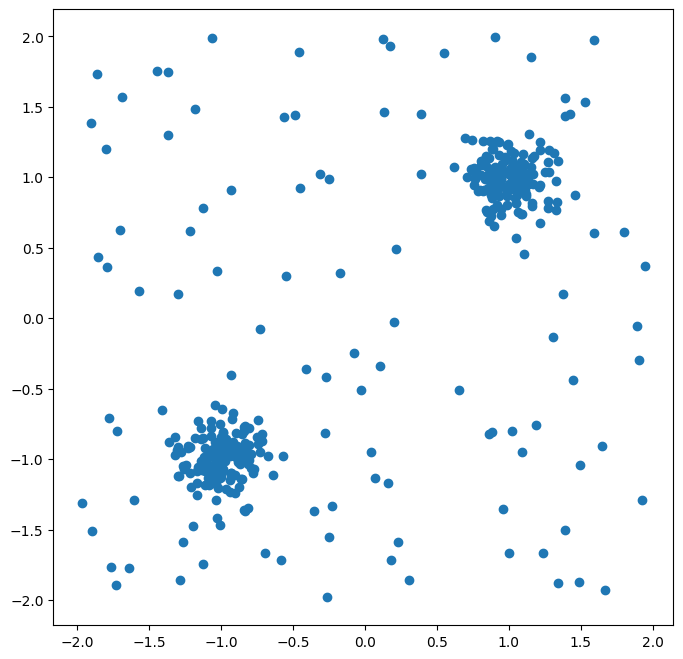

In [2]:
outliers_percentage = 0.35
inliers = 300
outliers = int(inliers * outliers_percentage)


data = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[.3, .3],
                  n_samples=inliers, random_state=0)[0]

data = scale(data)
data = np.concatenate([data, 
                       (np.random.rand(outliers, 2)-.5)*4.])

plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1])
plt.show()

What we expect from a good outlier algorithm is that all the samples far away from the two main clusters are labeled as outliers. This can be obtained considering as outliers the samples with a high quantization error.

To test this idea we have to 1) train a SOM, 2) compute the quantization error, 3) set a treshold for the quantization error:

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: tensor(0.4805)
Error treshold: 0.3517396986484522


/work/minisom.py:146: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


Text(0, 0.5, 'frequency')

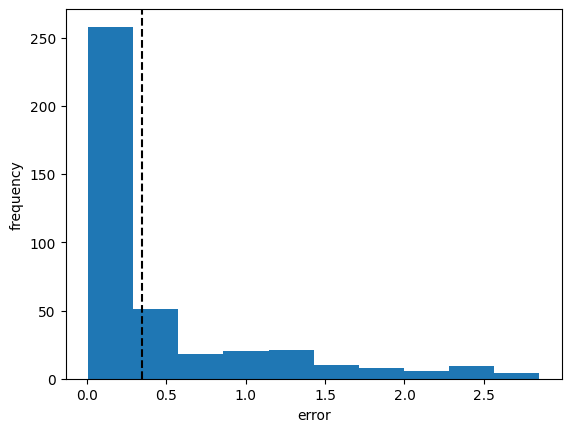

In [3]:
data = torch.tensor(data, dtype=torch.float32, device=device)
som = MiniSom(2, 1, data.shape[1], sigma=1, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10, device=device)


som.train(data, 100, random_order=False, verbose=True)  # random training

quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)+5)

print('Error treshold:', error_treshold)

is_outlier = quantization_errors > error_treshold

plt.hist(quantization_errors)
plt.axvline(error_treshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

This histogram shows the frequency of the quantization error. The dashed line represents the treshold picked to label the outliers. We can see that most of the samples have a low quantization error and the errors higher than the treshold are much more rare. (Notice that we were able to set a good treshold as we knew the percentage of outliers in our data. This is usually a parameter to tune experimentally.)

We are now ready to plot our dataset again highlighting the outliers with a different color:

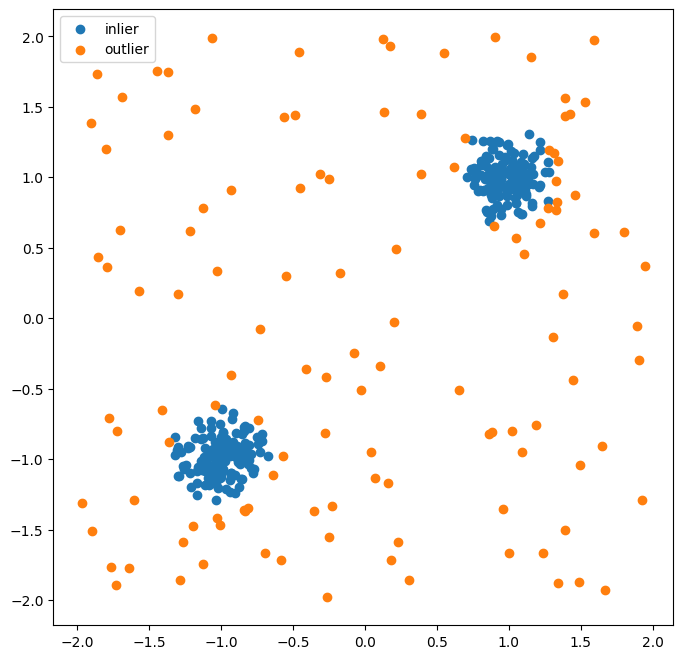

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(data[~is_outlier, 0], data[~is_outlier, 1],
            label='inlier')
plt.scatter(data[is_outlier, 0], data[is_outlier, 1],
            label='outlier')
plt.legend()
plt.savefig('resulting_images/som_outliers_detection.png')
plt.show()

We can also try the same on a different dataset:

In [5]:
from sklearn.datasets import make_circles
data = make_circles(noise=.1, n_samples=inliers, random_state=0)[0]
data = scale(data)
data = np.concatenate([data, 
                       (np.random.rand(outliers, 2)-.5)*4.])

data = torch.tensor(data, dtype=torch.float32)
som = MiniSom(5, 5, data.shape[1], sigma=1, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)


som.train_batch(data, 100, verbose=True)  
quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)+5)
is_outlier = quantization_errors > error_treshold

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: tensor(0.3681)


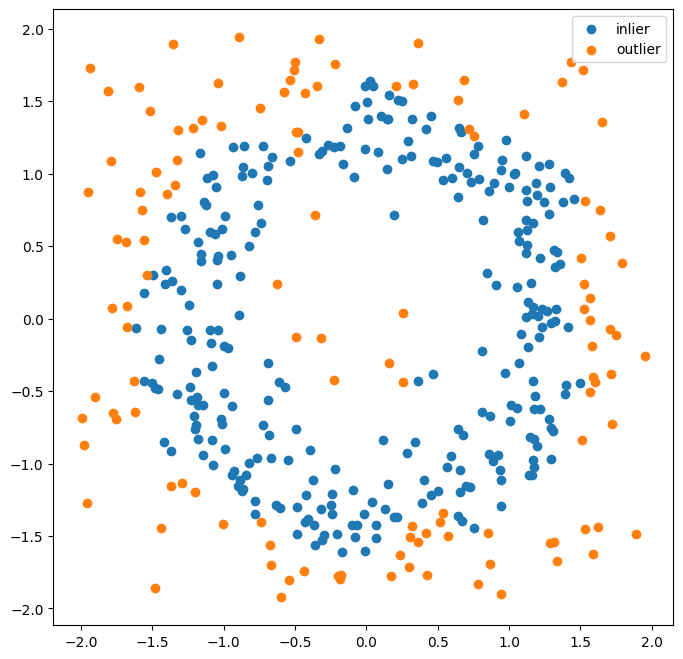

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(data[~is_outlier, 0], data[~is_outlier, 1],
            label='inlier')
plt.scatter(data[is_outlier, 0], data[is_outlier, 1],
            label='outlier')

plt.legend()
plt.savefig('resulting_images/som_outliers_detection_circle.png')
plt.show()